In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from gprofiler import GProfiler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [31]:
# Load your dataset
df = pd.read_excel("ProteinList-Final-MaxLFQ_2D culture.xlsx")

# Rename sample columns
rename_dict = {
    "241016mk-06_BM_EXO_1_Slot1-01_1_13877": "BM1",
    "241016mk-07_BM_EXO_2_Slot1-02_1_13878": "BM2",
    "241016mk-08_BM_EXO_3_Slot1-03_1_13879": "BM3",
    "241016mk-11_iMSC_EXO_1_Slot1-04_1_13882": "iMSC1",
    "241016mk-12_iMSC_EXO_2_Slot1-05_1_13889": "iMSC2",
    "241016mk-15_iMSC_EXO_3_Slot1-06_1_13892": "iMSC3",
    "241016mk-18_iPS_EXO_1_Slot1-07_1_13895": "iPS1",
    "241016mk-21_iPS_EXO_2_Slot1-08_1_13898": "iPS2",
    "241016mk-24_iPS_EXO_3_Slot1-09_1_13901": "iPS3",
}

df = df.rename(columns=rename_dict)
gene_names = df["Genes"]  # Adjust if the column name differs

# Now extract intensity columns with new names
data_columns = list(rename_dict.values())
df_filtered = df[data_columns].copy()


# 1) Filter out proteins with too many missing values
Remove proteins with >50% missing values across samples.



In [33]:
df_filtered = df_filtered.dropna(thresh=len(data_columns) * 0.5)
df_filtered

,BM1,BM2,BM3,iMSC1,iMSC2,iMSC3,iPS1,iPS2,iPS3
1,26192.70,23649.80,21583.10,9861.40,NaN,8988.63,69064.30,39854.40,33247.00
4,10514.50,14967.10,15362.60,5732.52,NaN,NaN,52761.20,53554.70,57251.50
9,12851.50,16663.60,15209.80,4026.83,9502.07,NaN,47917.40,45565.70,56130.50
13,5980.79,8314.94,8148.08,7085.20,NaN,5991.04,57302.20,77059.50,82254.90
17,47760.40,56795.80,64051.70,22317.20,27767.50,35741.40,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4172,8661.53,NaN,8951.30,NaN,NaN,NaN,5851.20,3657.82,3658.19
4175,17205.50,5570.33,3911.57,14963.10,5331.70,16214.00,176098.00,161068.00,133907.00
4176,17202.50,30449.60,33249.90,31535.00,27023.80,33067.50,207598.00,183784.00,203525.00
4182,170353.00,NaN,35116.00,NaN,NaN,439790.00,510703.00,491408.00,520036.00


# 2) Impute missing values
Replace remaining NaNs with the minimum detected value per protein (common in proteomics).


In [34]:
df_filtered = df_filtered.apply(lambda x: x.fillna(x.min()), axis=1)
df_filtered

,BM1,BM2,BM3,iMSC1,iMSC2,iMSC3,iPS1,iPS2,iPS3
1,26192.70,23649.80,21583.10,9861.40,8988.63,8988.63,69064.30,39854.40,33247.00
4,10514.50,14967.10,15362.60,5732.52,5732.52,5732.52,52761.20,53554.70,57251.50
9,12851.50,16663.60,15209.80,4026.83,9502.07,4026.83,47917.40,45565.70,56130.50
13,5980.79,8314.94,8148.08,7085.20,5980.79,5991.04,57302.20,77059.50,82254.90
17,47760.40,56795.80,64051.70,22317.20,27767.50,35741.40,22317.20,22317.20,22317.20
...,...,...,...,...,...,...,...,...,...
4172,8661.53,3657.82,8951.30,3657.82,3657.82,3657.82,5851.20,3657.82,3658.19
4175,17205.50,5570.33,3911.57,14963.10,5331.70,16214.00,176098.00,161068.00,133907.00
4176,17202.50,30449.60,33249.90,31535.00,27023.80,33067.50,207598.00,183784.00,203525.00
4182,170353.00,35116.00,35116.00,35116.00,35116.00,439790.00,510703.00,491408.00,520036.00


# 3) Remove proteins with near-zero variance
PCA works best when variation is present. Remove proteins with little to no expression change.

In [36]:
selector = VarianceThreshold(threshold=1.0)  # Adjust as needed
filtered_data = selector.fit_transform(df_filtered)
df_filtered

,BM1,BM2,BM3,iMSC1,iMSC2,iMSC3,iPS1,iPS2,iPS3
1,26192.70,23649.80,21583.10,9861.40,8988.63,8988.63,69064.30,39854.40,33247.00
4,10514.50,14967.10,15362.60,5732.52,5732.52,5732.52,52761.20,53554.70,57251.50
9,12851.50,16663.60,15209.80,4026.83,9502.07,4026.83,47917.40,45565.70,56130.50
13,5980.79,8314.94,8148.08,7085.20,5980.79,5991.04,57302.20,77059.50,82254.90
17,47760.40,56795.80,64051.70,22317.20,27767.50,35741.40,22317.20,22317.20,22317.20
...,...,...,...,...,...,...,...,...,...
4172,8661.53,3657.82,8951.30,3657.82,3657.82,3657.82,5851.20,3657.82,3658.19
4175,17205.50,5570.33,3911.57,14963.10,5331.70,16214.00,176098.00,161068.00,133907.00
4176,17202.50,30449.60,33249.90,31535.00,27023.80,33067.50,207598.00,183784.00,203525.00
4182,170353.00,35116.00,35116.00,35116.00,35116.00,439790.00,510703.00,491408.00,520036.00


# 4) Log-transform the data 
to normalize skewed distributions

In [37]:
filtered_data = pd.DataFrame(filtered_data, index=df_filtered.index, columns=data_columns)
filtered_data["Genes"] = gene_names.loc[filtered_data.index]  # Reattach gene names
# Move "Gene Name" to index for heatmap
filtered_data.set_index("Genes", inplace=True)

# Log2 transform for better visualization
filtered_data = np.log2(filtered_data + 1)
filtered_data

,BM1,BM2,BM3,iMSC1,iMSC2,iMSC3,iPS1,iPS2,iPS3
Genes,,,,,,,,,
YWHAE,14.676932,14.529601,14.397681,13.267723,13.134046,13.134046,16.075673,15.282488,15.020980
YWHAQ,13.360230,13.869603,13.907229,12.485205,12.485205,12.485205,15.687217,15.708753,15.805051
PPP2R1A,13.649761,14.024499,13.892808,11.975787,13.214178,11.975787,15.548292,15.475692,15.776523
SLC3A2,12.546362,13.021664,12.992421,12.790796,12.546362,12.548832,15.806328,16.233704,16.327832
NT5E,15.543558,15.793522,15.966972,14.445933,14.761162,15.125349,14.445933,14.445933,14.445933
...,...,...,...,...,...,...,...,...,...
XPNPEP1,13.080573,11.837163,13.128043,11.837163,11.837163,11.837163,12.514763,11.837163,11.837309
XRCC5,14.070666,12.443806,11.933901,13.869218,12.380650,13.985041,17.426027,17.297319,17.030883
XRCC6,14.070414,14.894183,15.021106,14.944712,14.721996,15.013170,17.663440,17.487659,17.634854


## Perform PCA


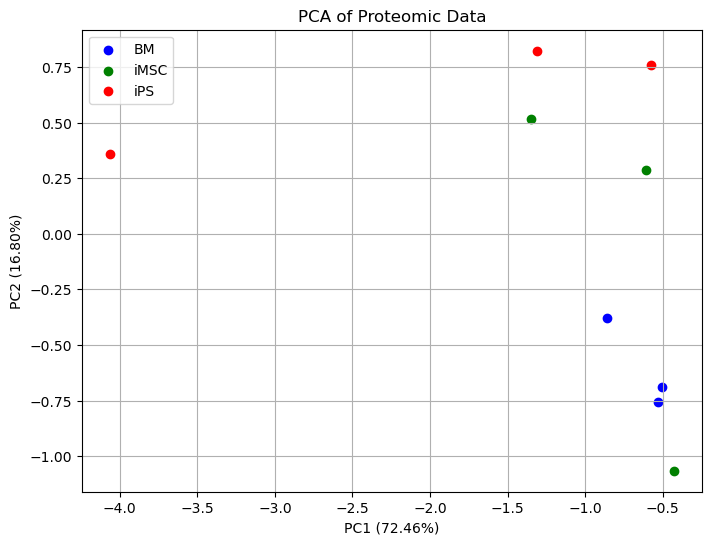

In [38]:
# Standardize the data
scaler = StandardScaler()
protein_data_scaled = scaler.fit_transform(filtered_data)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(protein_data_scaled)

# Define colors for groups
sample_groups = ["BM"] * 3 + ["iMSC"] * 3 + ["iPS"] * 3
colors = {"BM": "blue", "iMSC": "green", "iPS": "red"}

# Track plotted groups to avoid duplicate legend entries
plotted_groups = set()

plt.figure(figsize=(8, 6))
for i, label in enumerate(data_columns):
    group = sample_groups[i]
    if group not in plotted_groups:  # Add label only once per group
        plt.scatter(pca_result[i, 0], pca_result[i, 1], color=colors[group], label=group)
        plotted_groups.add(group)
    else:
        plt.scatter(pca_result[i, 0], pca_result[i, 1], color=colors[group])

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA of Proteomic Data")
plt.legend()
plt.grid(True)
plt.show()


## Hierarchical Clustering & Heatmap

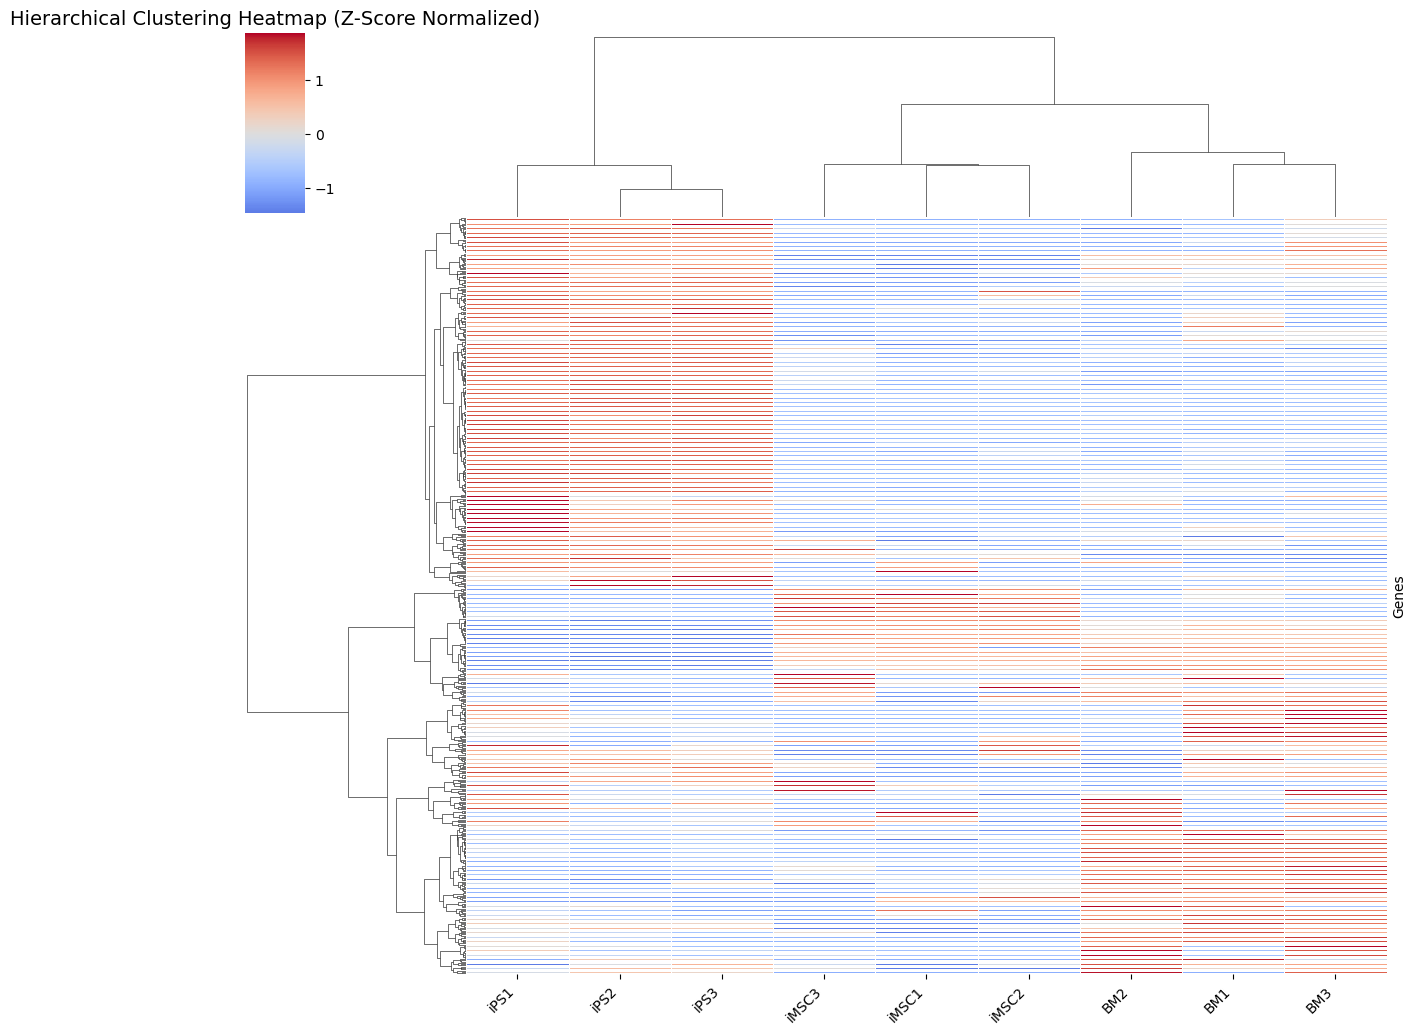

In [41]:
# Apply Z-score normalization (row-wise, across samples)
filtered_data_zscore = filtered_data.apply(zscore, axis=1)

# Remove NaNs (sometimes all-zero rows cause NaNs after z-score)
filtered_data_zscore = filtered_data_zscore.dropna()


# Create hierarchical clustering heatmap with Z-scored data
g = sns.clustermap(
    filtered_data_zscore,  # Use Z-scored data
    method="ward",
    cmap="coolwarm",
    center=0,  # Ensure colors are balanced around zero
    robust=True,  # Reduce impact of extreme values
    linewidths=0.5,
    xticklabels=True,  
    yticklabels=False,  # Hide gene names
    figsize=(12, 10)
)

# Improve X-axis label visibility
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.title("Hierarchical Clustering Heatmap (Z-Score Normalized)", fontsize=14)
plt.show()



In [47]:
# Define sample groups
BM = filtered_data.loc[:, ["BM1", "BM2", "BM3"]]
iMSC = filtered_data.loc[:, ["iMSC1", "iMSC2", "iMSC3"]]
iPS = filtered_data.loc[:, ["iPS1", "iPS2", "iPS3"]]

# Compute fold change (mean expression ratio) and p-values
diff_expr_results = {}
for protein in filtered_data.index:  # Use filtered_data.index instead of protein_data.index
    fold_change_BM_iPS = BM.loc[protein].mean() / iPS.loc[protein].mean()
    p_value_BM_iPS = ttest_ind(BM.loc[protein], iPS.loc[protein], equal_var=False).pvalue

    fold_change_iMSC_iPS = iMSC.loc[protein].mean() / iPS.loc[protein].mean()
    p_value_iMSC_iPS = ttest_ind(iMSC.loc[protein], iPS.loc[protein], equal_var=False).pvalue

    diff_expr_results[protein] = [fold_change_BM_iPS, p_value_BM_iPS, fold_change_iMSC_iPS, p_value_iMSC_iPS]

# Convert to DataFrame
diff_expr_df = pd.DataFrame.from_dict(diff_expr_results, orient='index',
                                      columns=["FoldChange_BM_iPS", "PValue_BM_iPS", "FoldChange_iMSC_iPS", "PValue_iMSC_iPS"])

# Apply significance threshold (p-value < 0.05) for BM vs iPS and iMSC vs iPS
significant_proteins = diff_expr_df[(diff_expr_df["PValue_BM_iPS"] < 0.05) | (diff_expr_df["PValue_iMSC_iPS"] < 0.05)]

# Save results
diff_expr_df.to_csv("differential_expression_results.csv")
print("Significant proteins:", significant_proteins.shape[0])


C:\Users\drzia\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\drzia\AppData\Local\Temp\ipykernel_14884\2605190905.py:9: RuntimeWarning: invalid value encountered in scalar divide
  fold_change_BM_iPS = BM.loc[protein].mean() / iPS.loc[protein].mean()
C:\Users\drzia\AppData\Local\Temp\ipykernel_14884\2605190905.py:12: RuntimeWarning: invalid value encountered in scalar divide
  fold_change_iMSC_iPS = iMSC.loc[protein].mean() / iPS.loc[protein].mean()
C:\Users\drzia\AppData\Local\Temp\ipykernel_14884\2605190905.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  fold_change_BM_iPS = BM.loc[protein].mean() / iPS.loc[protein].mean()
C:\Users\drzia\AppData\Local\Temp\ipykernel_14884\2605190905.py:12: RuntimeWarning: divide by zero encount

Significant proteins: 420


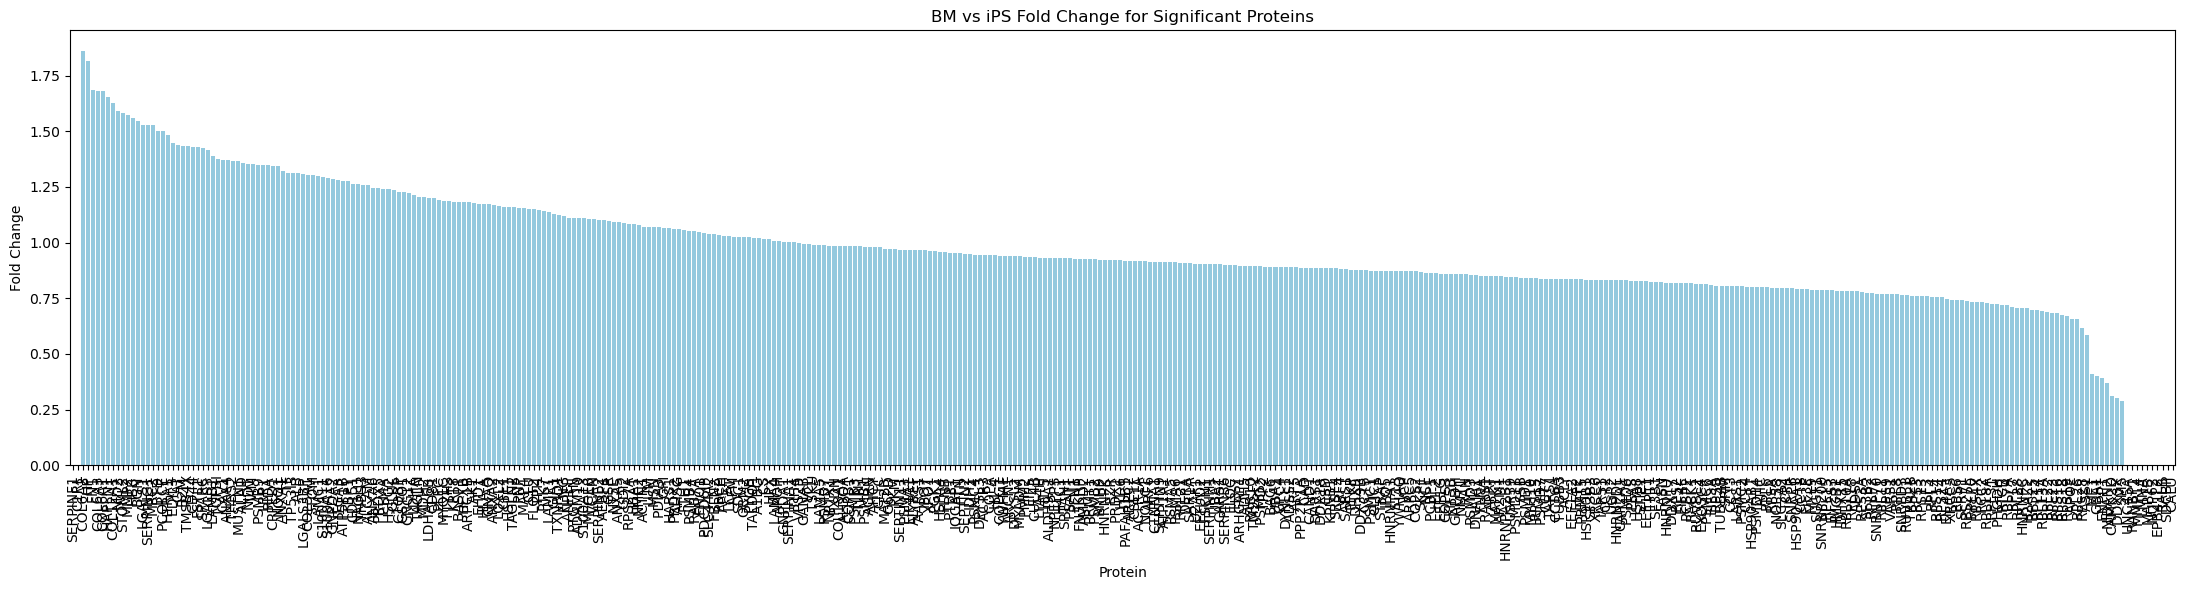

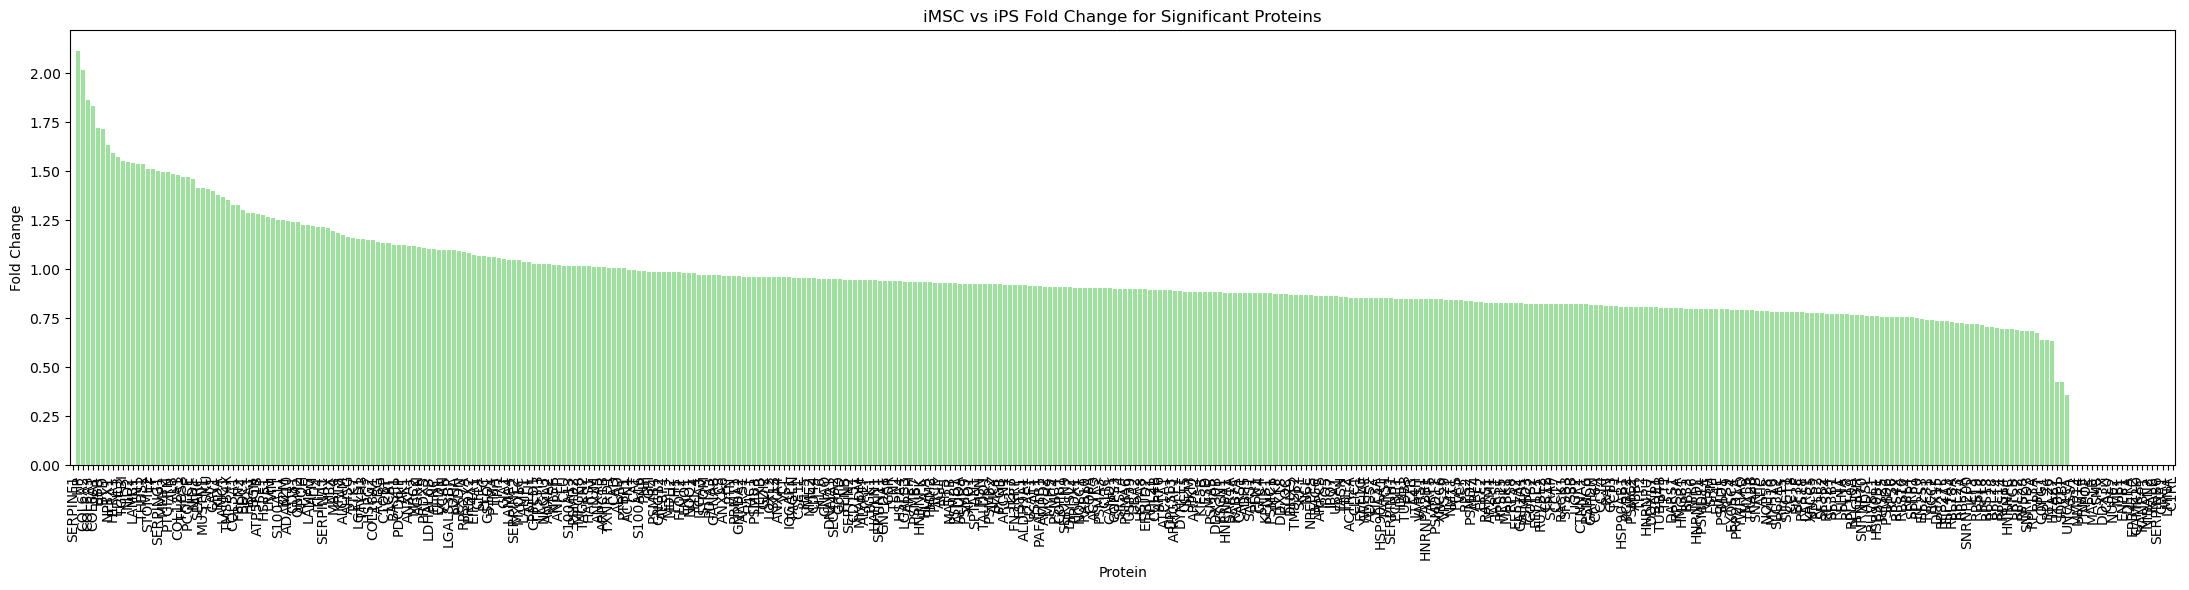

In [59]:

# Sort significant proteins by FoldChange_BM_iPS
significant_proteins_sorted_BM_iPS = significant_proteins.sort_values(by="FoldChange_BM_iPS", ascending=False)

# Plot fold changes for BM vs iPS
plt.figure(figsize=(22, 6))

# Select the fold change values for BM vs iPS
significant_proteins_fc_BM_iPS = significant_proteins_sorted_BM_iPS[["FoldChange_BM_iPS"]].reset_index()

# Plot using seaborn
sns.barplot(data=significant_proteins_fc_BM_iPS, x='index', y='FoldChange_BM_iPS', color='skyblue')

# Rotate labels for better readability
plt.xticks(rotation=90)

# Title and labels
plt.title('BM vs iPS Fold Change for Significant Proteins')
plt.xlabel('Protein')
plt.ylabel('Fold Change')

# Show plot
plt.tight_layout()
plt.show()

# Sort significant proteins by FoldChange_iMSC_iPS
significant_proteins_sorted_iMSC_iPS = significant_proteins.sort_values(by="FoldChange_iMSC_iPS", ascending=False)

# Plot fold changes for iMSC vs iPS
plt.figure(figsize=(22, 6))

# Select the fold change values for iMSC vs iPS
significant_proteins_fc_iMSC_iPS = significant_proteins_sorted_iMSC_iPS[["FoldChange_iMSC_iPS"]].reset_index()

# Plot using seaborn
sns.barplot(data=significant_proteins_fc_iMSC_iPS, x='index', y='FoldChange_iMSC_iPS', color='lightgreen')

# Rotate labels for better readability
plt.xticks(rotation=90)

# Title and labels
plt.title('iMSC vs iPS Fold Change for Significant Proteins')
plt.xlabel('Protein')
plt.ylabel('Fold Change')

# Show plot
plt.tight_layout()
plt.show()


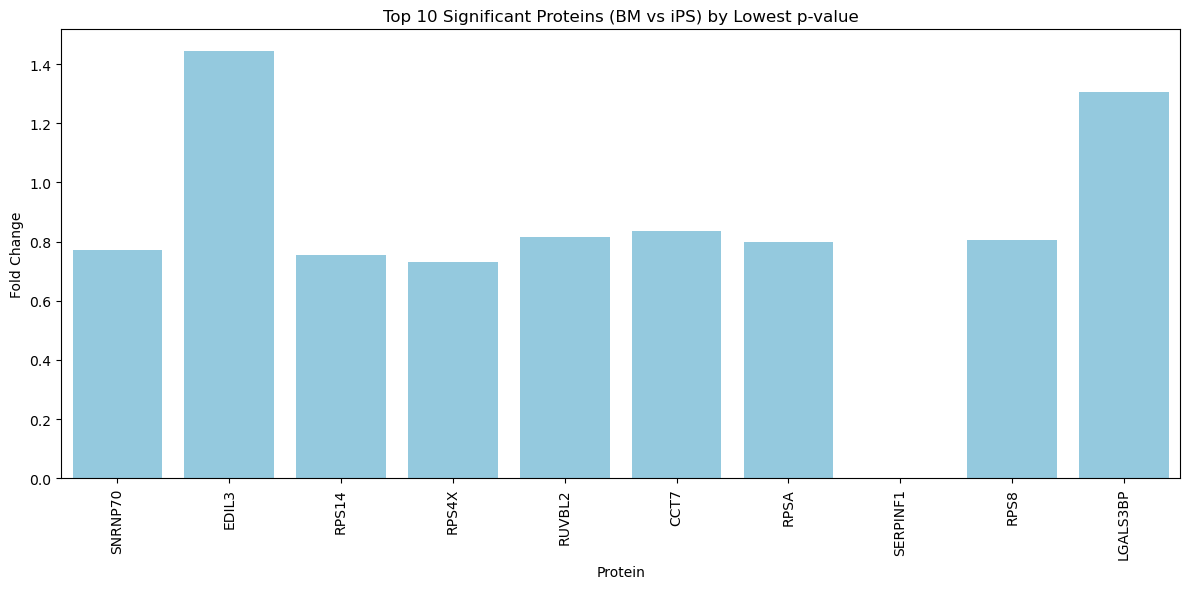

In [55]:
# Sort by the lowest p-value for BM vs iPS and iMSC vs iPS
top_proteins = significant_proteins.sort_values(by=["PValue_BM_iPS"]).head(10)

# Plot fold changes for the top 10 significant proteins (BM vs iPS)
plt.figure(figsize=(12, 6))

# Select the fold change values for BM vs iPS
top_proteins_fc_BM_iPS = top_proteins[["FoldChange_BM_iPS"]].reset_index()

# Plot using seaborn
sns.barplot(data=top_proteins_fc_BM_iPS, x='index', y='FoldChange_BM_iPS', color='skyblue')

# Rotate labels for better readability
plt.xticks(rotation=90)

# Title and labels
plt.title('Top 10 Significant Proteins (BM vs iPS) by Lowest p-value')
plt.xlabel('Protein')
plt.ylabel('Fold Change')

# Show plot
plt.tight_layout()
plt.show()



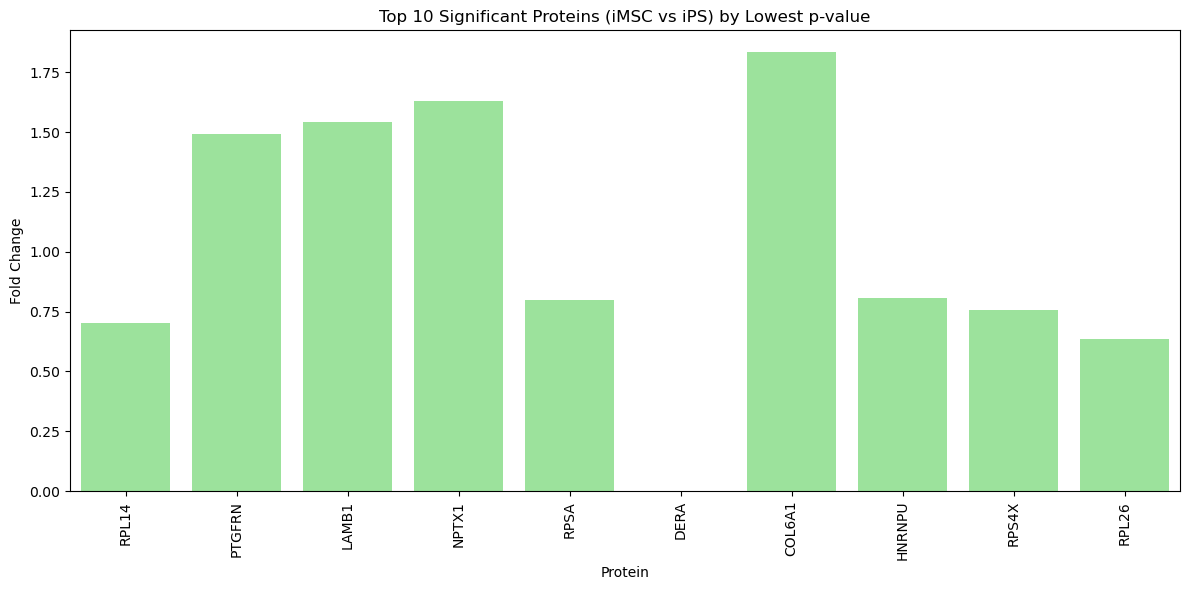

In [56]:
# Sort by the lowest p-value for BM vs iPS and iMSC vs iPS
top_proteins = significant_proteins.sort_values(by=["PValue_iMSC_iPS"]).head(10)


# Plot fold changes for the top 10 significant proteins (iMSC vs iPS)
plt.figure(figsize=(12, 6))

# Select the fold change values for iMSC vs iPS
top_proteins_fc_iMSC_iPS = top_proteins[["FoldChange_iMSC_iPS"]].reset_index()

# Plot using seaborn
sns.barplot(data=top_proteins_fc_iMSC_iPS, x='index', y='FoldChange_iMSC_iPS', color='lightgreen')

# Rotate labels for better readability
plt.xticks(rotation=90)

# Title and labels
plt.title('Top 10 Significant Proteins (iMSC vs iPS) by Lowest p-value')
plt.xlabel('Protein')
plt.ylabel('Fold Change')

# Show plot
plt.tight_layout()
plt.show()

In [61]:


# Filter significant proteins for BM vs iPS (p-value ≤ 0.05)
significant_BM_iPS = significant_proteins[significant_proteins["PValue_BM_iPS"] <= 0.05]
significant_BM_iPS_list = significant_BM_iPS.index.tolist()

# Run GO analysis for BM vs iPS
gp_BM_iPS = GProfiler(return_dataframe=True)
go_results_BM_iPS = gp_BM_iPS.profile(organism="hsapiens", query=significant_BM_iPS_list)

# Show top results for BM vs iPS
print("BM vs iPS GO Enrichment:")
print(go_results_BM_iPS[["name", "p_value"]].head(10))

# Filter significant proteins for iMSC vs iPS (p-value ≤ 0.05)
significant_iMSC_iPS = significant_proteins[significant_proteins["PValue_iMSC_iPS"] <= 0.05]
significant_iMSC_iPS_list = significant_iMSC_iPS.index.tolist()

# Run GO analysis for iMSC vs iPS
gp_iMSC_iPS = GProfiler(return_dataframe=True)
go_results_iMSC_iPS = gp_iMSC_iPS.profile(organism="hsapiens", query=significant_iMSC_iPS_list)

# Show top results for iMSC vs iPS
print("iMSC vs iPS GO Enrichment:")
print(go_results_iMSC_iPS[["name", "p_value"]].head(10))


BM vs iPS GO Enrichment:
                                       name        p_value
0                     extracellular vesicle  7.496623e-134
1                   extracellular organelle  8.291835e-134
2  extracellular membrane-bounded organelle  8.291835e-134
3                     extracellular exosome  1.250564e-133
4                       extracellular space  8.894186e-104
5                                   vesicle  1.191867e-100
6                      extracellular region   1.093401e-95
7                                   cytosol   1.811620e-64
8                            focal adhesion   4.842007e-51
9                   cell-substrate junction   2.640003e-50
iMSC vs iPS GO Enrichment:
                                          name        p_value
0                        extracellular vesicle  2.395114e-124
1     extracellular membrane-bounded organelle  2.634076e-124
2                      extracellular organelle  2.634076e-124
3                        extracellular exosome  4.3

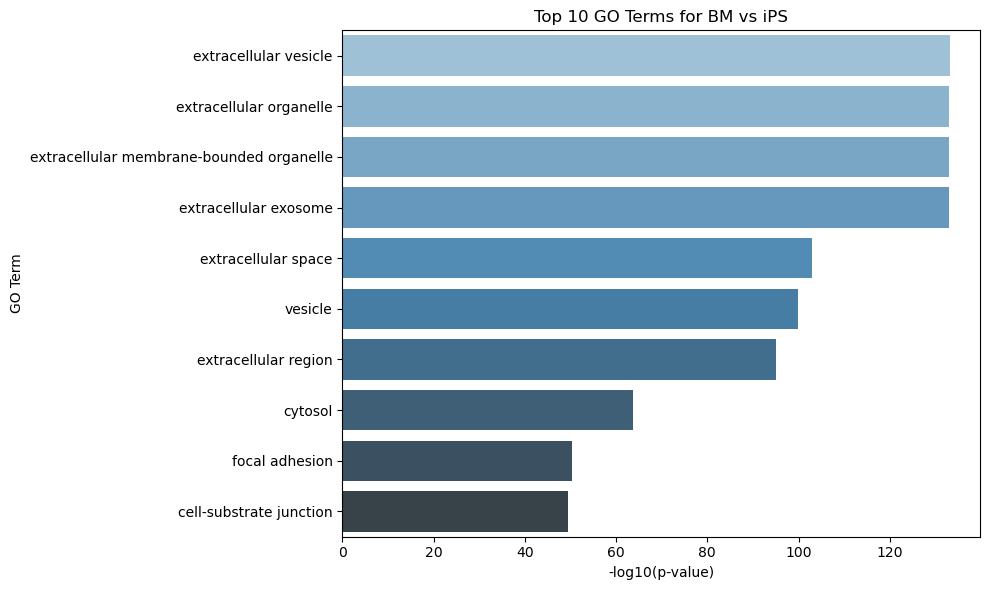

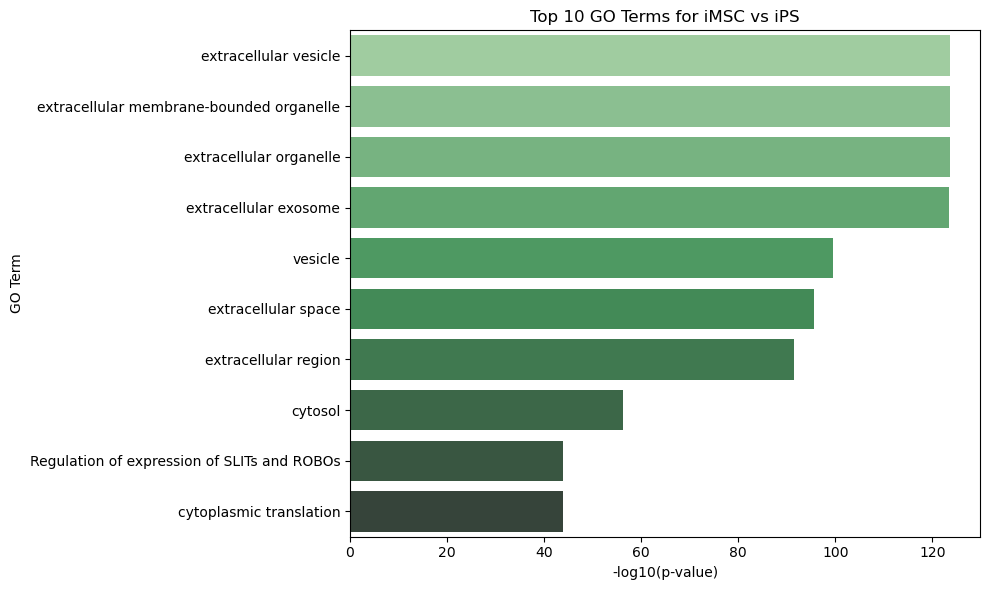

In [63]:

# Plot for BM vs iPS
top_go_terms_BM_iPS = go_results_BM_iPS[['name', 'p_value']].sort_values(by='p_value').head(10)

# Transform p-values to -log10(p-value)
top_go_terms_BM_iPS['-log10_pvalue'] = -np.log10(top_go_terms_BM_iPS['p_value'])

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top_go_terms_BM_iPS, x='-log10_pvalue', y='name', palette='Blues_d')
plt.title('Top 10 GO Terms for BM vs iPS')
plt.xlabel('-log10(p-value)')
plt.ylabel('GO Term')
plt.tight_layout()
plt.show()

# Plot for iMSC vs iPS
top_go_terms_iMSC_iPS = go_results_iMSC_iPS[['name', 'p_value']].sort_values(by='p_value').head(10)

# Transform p-values to -log10(p-value)
top_go_terms_iMSC_iPS['-log10_pvalue'] = -np.log10(top_go_terms_iMSC_iPS['p_value'])

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top_go_terms_iMSC_iPS, x='-log10_pvalue', y='name', palette='Greens_d')
plt.title('Top 10 GO Terms for iMSC vs iPS')
plt.xlabel('-log10(p-value)')
plt.ylabel('GO Term')
plt.tight_layout()
plt.show()

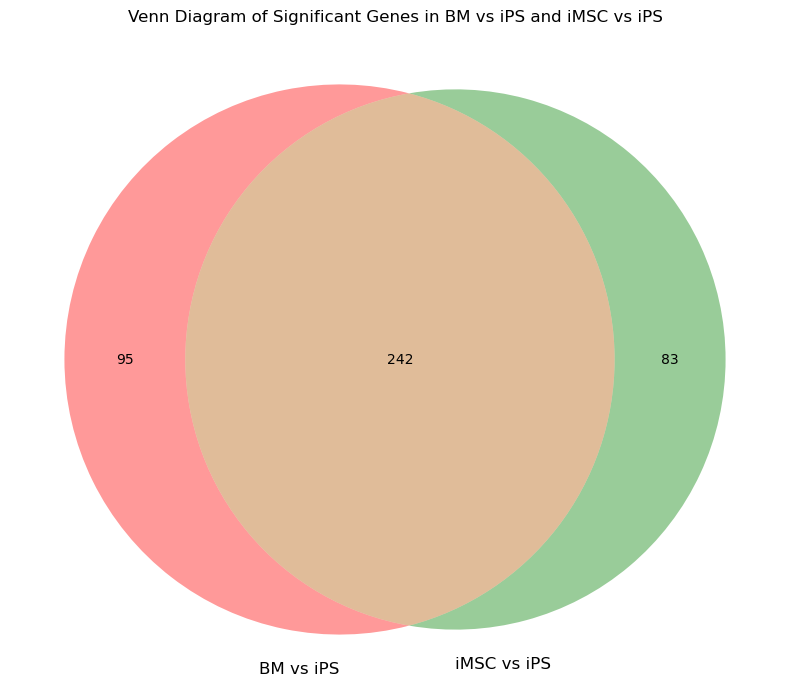

In [67]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Get the significant proteins for BM vs iPS (p-value < 0.05)
significant_proteins_BM_iPS = significant_proteins[significant_proteins["PValue_BM_iPS"] < 0.05]
significant_proteins_iMSC_iPS = significant_proteins[significant_proteins["PValue_iMSC_iPS"] < 0.05]

# Get the list of significant genes for each comparison
significant_BM_iPS_genes = significant_proteins_BM_iPS.index.tolist()  # BM vs iPS significant genes
significant_iMSC_iPS_genes = significant_proteins_iMSC_iPS.index.tolist()  # iMSC vs iPS significant genes

# Create a Venn diagram for the significant genes
plt.figure(figsize=(8, 8))
venn2([set(significant_BM_iPS_genes), set(significant_iMSC_iPS_genes)], 
      set_labels=('BM vs iPS', 'iMSC vs iPS'))

# Show the plot
plt.title('Venn Diagram of Significant Genes in BM vs iPS and iMSC vs iPS')
plt.tight_layout()
plt.show()
